In [86]:
pip install tokenizers

In [87]:
pip install rouge

In [146]:
from pathlib import Path
import os
import pandas as pd
import nltk
from nltk.tokenize import WordPunctTokenizer 
from nltk.translate.bleu_score import sentence_bleu
import statistics
from rouge import Rouge
import numpy as np
import math
from matplotlib import pyplot as plt

# the folder 'text' contains all the files
#paths = [str(x) for x in Path("./data/").glob("**/*.txt")]

from google.colab import drive
drive.mount('/content/drive')

# Import from external file
X_train = pd.read_csv('/content/drive/My Drive/Data/output/x_train.csv')
X_test = pd.read_csv("/content/drive/My Drive/Data/output/x_test.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
pip install transformers

In [25]:
import tensorflow as tf

from transformers import GPT2Config, TFGPT2LMHeadModel, GPT2Tokenizer
# loading tokenizer from the saved model path
#tokenizer = GPT2Tokenizer.from_pretrained(save_path)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
'''
tokenizer.add_special_tokens({
  "eos_token": "</s>",
  "bos_token": "<s>",
  "unk_token": "<unk>",
  "pad_token": "<pad>",
  "mask_token": "<mask>"
})
'''
# creating the configurations from which the model can be made
config = GPT2Config(
  vocab_size=tokenizer.vocab_size,
  bos_token_id=tokenizer.bos_token_id,
  eos_token_id=tokenizer.eos_token_id
)
# creating the model
#model = TFGPT2LMHeadModel(config)
model = TFGPT2LMHeadModel.from_pretrained('gpt2')

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [26]:
single_string = ''
for i in range(len(X_train)):
  single_string += X_train['question'].iloc[i] + ' ' + tokenizer.bos_token + ' ' + X_train['answer'].iloc[i] + ' ' + tokenizer.eos_token + ' '
string_tokenized = tokenizer.encode(single_string)

Token indices sequence length is longer than the specified maximum sequence length for this model (410593 > 1024). Running this sequence through the model will result in indexing errors


In [27]:
'''
single_string = ''
for filename in paths:
  with open(filename, "r", encoding='utf-8') as f:
   x = f.read()
   single_string += x + tokenizer.eos_token
string_tokenized = tokenizer.encode(single_string)
'''

'\nsingle_string = \'\'\nfor filename in paths:\n  with open(filename, "r", encoding=\'utf-8\') as f:\n   x = f.read()\n   single_string += x + tokenizer.eos_token\nstring_tokenized = tokenizer.encode(single_string)\n'

In [28]:
#print(string_tokenized)

In [29]:
examples = []
block_size = 100
BATCH_SIZE = 12
BUFFER_SIZE = 1000
for i in range(0, len(string_tokenized) - block_size + 1, block_size):
  examples.append(string_tokenized[i:i + block_size])
#print(examples)
inputs, labels = [], []
for ex in examples:
  inputs.append(ex[:-1])
  labels.append(ex[1:])
  #print(labels)
dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [32]:
# defining our optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
# definining our loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric])

In [33]:
num_epoch = 10
history = model.fit(dataset, epochs=num_epoch)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


342/342 [==============================] - 104s 305ms/step - loss: 3.5338 - logits_loss: 3.5338 - logits_accuracy: 0.3504 - past_key_values_1_accuracy: 0.0022 - past_key_values_2_accuracy: 0.0020 - past_key_values_3_accuracy: 0.0015 - past_key_values_4_accuracy: 0.0045 - past_key_values_5_accuracy: 0.0023 - past_key_values_6_accuracy: 0.0020 - past_key_values_7_accuracy: 0.0014 - past_key_values_8_accuracy: 0.0021 - past_key_values_9_accuracy: 0.0012 - past_key_values_10_accuracy: 0.0015 - past_key_values_11_accuracy: 0.0011 - past_key_values_12_accuracy: 0.0016
Epoch 2/10
342/342 [==============================] - 104s 305ms/step - loss: 3.2618 - logits_loss: 3.2618 - logits_accuracy: 0.3777 - past_key_values_1_accuracy: 0.0022 - past_key_values_2_accuracy: 0.0020 - past_key_values_3_accuracy: 0.0015 - past_key_values_4_accuracy: 0.0045 - past_key_values_5_accuracy: 0.0023 - past_key_values_6_accuracy: 0.0020 - past_key_values_7_accuracy: 0.0013 - past_key_values_8_accuracy: 0.0020 - 

In [71]:
def predict(input_text):
  # encoding the input text
  input_text = input_text + ' ' + tokenizer.bos_token
  input_ids = tokenizer.encode(input_text, return_tensors='tf') 
  
  # getting out output
  beam_output = model.generate(
  input_ids,
  max_length = 1024,
  num_beams = 5,
  temperature = 0.7,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)
  predicted_ans = tokenizer.decode(beam_output[0])
  predicted_ans = predicted_ans[predicted_ans.find(tokenizer.bos_token)+len(tokenizer.bos_token):]
  predicted_ans.replace(tokenizer.eos_token, '')
  return predicted_ans

In [72]:
# Testing with custom test set
docs_new = ['What is coronavirus?',
            'What are symptoms of COVID',
            'What is COVID?',
            'I have a cough. Do I have corona?',
            'Does my friend have COVID?',
            'How many people in USA have COVID?',
            'How many people in the world have covid19?']


predicted_custom = []
for question in docs_new:
    predicted_custom.append(predict(question))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [73]:
# View results
results_custom = pd.DataFrame(data = {'Question': docs_new, 'Predicted Answer': predicted_custom})
results_custom

,Question,Predicted Answer
0,What is coronavirus?,Coronaviruses are a large family of viruses t...
1,What are symptoms of COVID,I am a PhD student in the Department of Compu...
2,What is COVID?,Coronavirus (COVID-19) is a new virus that ha...
3,I have a cough. Do I have corona?,Coronaviruses are a large family of viruses t...
4,Does my friend have COVID?,"Yes, she has. \n\nHer symptoms are similar to..."
5,How many people in USA have COVID?,The number of confirmed cases in the USA is c...
6,How many people in the world have covid19?,There are currently no known cases of COVID-1...


In [74]:
results_custom['Predicted Answer'].iloc[0]

' Coronaviruses are a large family of viruses that cause a range of respiratory diseases including colds, flu, and severe acute respiratory syndrome (SARS-CoV-2).  \n\nThe virus that causes COVID-19 is called the "common cold", and is caused by the common cold adenovirus.  The virus causes about 80% of the world\'s respiratory infections, according to the World Organisation for Animal Health (OIE), and it is thought to be mainly transmitted through respiratory droplets produced when an infected person coughs or sneezes.\n\n\n  In the United States, the most common form of infection is respiratory syncytial fluid (RSD), which is a fluid-like fluid that is expelled from the upper respiratory tract when a respiratory infection occurs. This fluid is then expelled into the air, where it can be inhaled by people who are nearby or have close contact with someone who has the virus. However, there is no known way to precisely measure the amount of RSD in a person’s airways, or how much is in it

In [75]:
predicted_answer = []
for question in X_test['question'].iloc[:80]:   # Split processing across different systems. This system processes 1-80 rows
  predicted_answer.append(predict(question))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad

In [76]:
df = pd.DataFrame(predicted_answer, columns= ['predicted answer'])
df

,predicted answer
0,There is a lot of misinformation out there ab...
1,The virus that causes COVID-19 is thought to ...
2,I am a PhD student in epidemiology at the Uni...
3,I am wondering if there is a legal basis for ...
4,I am a PhD student in bioinformatics at the U...
...,...
75,It’s possible that the virus that causes COVI...
76,"Currently, there is no evidence to suggest th..."
77,The virus that causes COVID-19 is thought to ...
78,I am a PhD student in the Department of Mecha...


In [77]:
# Save all results to file
df.to_csv('x_test_1.csv',index= False)

In [148]:
# Remove row with tokens > 1024 since max_length = 1024
X_test = X_test.drop(185)

In [156]:
# Import all results from external file
X_test_1 = pd.read_csv("/content/drive/My Drive/Data/output/x_test_1.csv")
X_test_2 = pd.read_csv("/content/drive/My Drive/Data/output/x_test_2.csv")
X_test_3 = pd.read_csv("/content/drive/My Drive/Data/output/x_test_3.csv")
X_test_4 = pd.read_csv("/content/drive/My Drive/Data/output/x_test_4.csv")
X_test_5 = pd.read_csv("/content/drive/My Drive/Data/output/x_test_5.csv")
X_test_6 = pd.read_csv("/content/drive/My Drive/Data/output/x_test_6.csv")

In [157]:
# Concat results and add them to dataframe
frames = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5, X_test_6]
X_test['predicted_answer'] = pd.concat(frames, ignore_index= True)
X_test

,Unnamed: 0,source,url,question,answer,wrong_answer,prep_answer,cluster,predicted_answer
0,127,biomedical,health.stackexchange.com,"As the German chancellor said today, by the en...",Some Canadian experts said 35% to 70% will be ...,This is a rough estimate based on how contagio...,some canadian experts said 35 to 70 will be ...,66,There is a lot of misinformation out there ab...
1,190,NDTV,https://www.ndtv.com/coronavirus/faq,How long does the virus survive on surfaces?,It is not certain how long the virus that caus...,Only wear a mask if you are ill with COVID-19 ...,it is not certain how long the virus that caus...,55,The virus that causes COVID-19 is thought to ...
2,631,general,travel.stackexchange.com,Someone I know booked a return flight on Air S...,The €250 compensation doesn't apply in extraor...,"Technically possible, but in practice very dif...",the eur250 compensation does not apply in extr...,48,I am a PhD student in epidemiology at the Uni...
3,211,expert,law.stackexchange.com,"Apparently, a new coronavirus related paid fam...",The Department of Labor has a page about the l...,It doesn’t even apply to the airline in curren...,the department of labor has a page about the l...,66,I am wondering if there is a legal basis for ...
4,120,biomedical,health.stackexchange.com,There's a ridiculous conspiracy theory spreadi...,I somewhat agree that it's difficult to debunk...,"New York State\n\nYes, I know that you don't l...",i somewhat agree that it is difficult to debun...,66,I am a PhD student in bioinformatics at the U...
...,...,...,...,...,...,...,...,...,...
254,202,expert,law.stackexchange.com,Right now there are large American states whic...,US Constitutional law generally recognizes the...,The relevant law is trademark law. The basic q...,us constitutional law generally recognizes the...,66,There is a lot of misinformation out there ab...
255,1,biomedical,biology.stackexchange.com,It's my understanding that the majority of sym...,Can someone die of the common cold?\n\nNo. \nT...,"The dash (""-"") does not represent a negative c...",can someone die of the common cold no. the ...,36,The main way the virus spreads is through res...
256,262,NY Times,https://www.nytimes.com/interactive/2020/world...,Want to give toward medical supplies?,[Relief International](https://www.ri.org/dona...,You can. Donor blood is not being used to trea...,relief international http://www.ri.org/donat...,66,\n Medical supplies are essential to the hea...
257,587,WHO,https://www.who.int/news-room/q-a-detail/contr...,Why is providing contraception/ family plannin...,Contraception and family planning information ...,No. Waste produced during the health care or h...,contraception and family planning information ...,33,"There is a lot of misinformation out there, a..."


In [159]:
# Compute Bleu score
tk = WordPunctTokenizer() 
bleu_score = []
for i in range(len(X_test)):
  prep_answer = tk.tokenize(X_test['prep_answer'].iloc[i])
  predicted_answer = tk.tokenize(X_test['predicted_answer'].iloc[i])
  bleu_score.append(sentence_bleu(prep_answer, predicted_answer))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [160]:
## Compute bleu scores
# Mean
statistics.mean(bleu_score)

0.3275430683833646

In [161]:
# Max
max(bleu_score)

0.49330550922616334

In [162]:
# Min
min(bleu_score)

0.05096423778824181

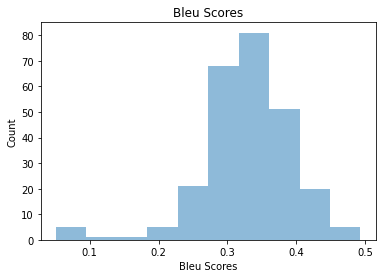

In [171]:
# Bleu score histogram

plt.hist(bleu_score, alpha=0.5)
plt.title('Bleu Scores')
plt.xlabel('Bleu Scores')
plt.ylabel('Count')

plt.show()


In [173]:
# Compute rogue scores
references = list(X_test.prep_answer)
candidates = list(X_test.predicted_answer)

rouge = Rouge()
scores = rouge.get_scores(candidates, references, avg=True)
scores

{'rouge-1': {'f': 0.18802168051490634,
  'p': 0.18812238566293757,
  'r': 0.32847448959945913},
 'rouge-2': {'f': 0.024310414606680535,
  'p': 0.02465121544290012,
  'r': 0.045447602517570136},
 'rouge-l': {'f': 0.15203930056145362,
  'p': 0.14124431247139915,
  'r': 0.25378533592157915}}